# Introduction
This notebook reproduces the results presented in *nanoTabPFN: A Lightweight and Educational Reimplementation of TabPFN*.


# Helper Functions

In [ ]:
from matplotlib import pyplot as plt
import functools
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import openml
import pandas as pd
from openml.tasks import TaskType
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, FunctionTransformer

"""
=================== DATA LOADING AND PREPROCESSING ===================
"""

def get_feature_preprocessor(X: np.ndarray | pd.DataFrame) -> ColumnTransformer:
    """
    fits a preprocessor that imputes NaNs, encodes categorical features and removes constant features

    Creates masks for numeric and categorical columns
    Creates pipelines to convert numeric columns to numbers and categorical columns as integers (ordinal encoding)
    Returns a ColumnTransformer that can be used like so:
    preprocessor = get_feature_preprocessor(df)
    X_processed = preprocessor.fit_transform(df)

    """
    X = pd.DataFrame(X)
    num_mask = []
    cat_mask = []
    for col in X:
        unique_non_nan_entries = X[col].dropna().unique()
        if len(unique_non_nan_entries) <= 1:
            num_mask.append(False)
            cat_mask.append(False)
            continue
        non_nan_entries = X[col].notna().sum()
        numeric_entries = pd.to_numeric(X[col], errors='coerce').notna().sum() # in case numeric columns are stored as strings
        num_mask.append(non_nan_entries == numeric_entries)
        cat_mask.append(non_nan_entries != numeric_entries)
        # num_mask.append(is_numeric_dtype(X[col]))  # Assumes pandas dtype is correct

    num_mask = np.array(num_mask)
    cat_mask = np.array(cat_mask)

    num_transformer = Pipeline([
        ("to_pandas", FunctionTransformer(lambda x: pd.DataFrame(x) if not isinstance(x, pd.DataFrame) else x)), # to apply pd.to_numeric of pandas
        ("to_numeric", FunctionTransformer(lambda x: x.apply(pd.to_numeric, errors='coerce').to_numpy())), # in case numeric columns are stored as strings
    ])
    cat_transformer = Pipeline([
        ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_mask),
            ('cat', cat_transformer, cat_mask)
        ]
    )
    return preprocessor

def get_openml_datasets(
        max_features_eval: int = 10, 
        new_instances_eval: int = 200, 
        target_classes_filter: int = 2,
        **kwargs,
        ) -> dict[str, tuple[np.ndarray, np.ndarray]]:
    """
    Load OpenML tabarena datasets with at most `max_features` features and subsampled (stratified) to `new_instances` instances.



    This function:
    Loads a curated list of OpenML datasets.
    Filters datasets based on:
    Number of features
    Number of classes
    Missing values
    Class balance
    Optionally subsamples the dataset to a manageable number of instances.
    Converts data to numeric arrays and encodes labels.
    Returns a dictionary of fully preprocessed (X, y) datasets ready for ML experiments.

    """
    task_ids = [
        363612, 363613, 363614, 363615, 363616, 363618, 363619, 363620,
        363621, 363623, 363624, 363625, 363626, 363627, 363628, 363629,
        363630, 363631, 363632, 363671, 363672, 363673, 363674, 363675,
        363676, 363677, 363678, 363679, 363681, 363682, 363683, 363684,
        363685, 363686, 363689, 363691, 363693, 363694, 363696, 363697,
        363698, 363699, 363700, 363702, 363704, 363705, 363706, 363707,
        363708, 363711, 363712
    ] # TabArena v0.1
    datasets = {}
    for task_id in task_ids:
        task = openml.tasks.get_task(task_id, download_splits=False)
        if task.task_type_id != TaskType.SUPERVISED_CLASSIFICATION:
            continue  # skip task, only classification
        dataset = task.get_dataset(download_data=False)

        if dataset.qualities["NumberOfFeatures"] > max_features_eval or (dataset.qualities["NumberOfClasses"] > target_classes_filter) or dataset.qualities["PercentageOfInstancesWithMissingValues"] > 0 or dataset.qualities["MinorityClassPercentage"] < 2.5:
            continue
        X, y, categorical_indicator, attribute_names = dataset.get_data(
            target=task.target_name, dataset_format="dataframe"
        )
        if new_instances_eval < len(y):
            _, X_sub, _, y_sub = train_test_split(
                X, y,
                test_size=new_instances_eval,
                stratify=y,
                random_state=0,
            )
        else:
            X_sub = X
            y_sub = y
        
        X = X_sub.to_numpy(copy=True)
        y = y_sub.to_numpy(copy=True)
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        preprocessor = get_feature_preprocessor(X)
        X = preprocessor.fit_transform(X)
        datasets[dataset.name] = (X, y)
    return datasets

"""
=================== EVALUATION ===================
"""

_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def eval_model(model, datasets):
    """Evaluates a model on multiple datasets and returns metrics
    
    This method takes a model we want to evaluate as input, and a dictionnary of datasets where the key is the name of the dataset
    and the value being a tuple (X,y) of the features and labels 
    It then does a 5 fold cross validation for every dataset, calculating its Roc_Auc_score 
    It returns a dictionnary {dataset_name/ROC_AUC: roc_auc_score} with also an average of this metric over all datasets 
    """ 
    metrics = {}
    for dataset_name, (X,y)  in datasets.items():
        targets = []
        probabilities = []
        
        for train_idx, test_idx in _skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test  = y[train_idx], y[test_idx]
            targets.append(y_test)
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)
            if y_proba.shape[1] == 2:  # binary classification with neural network
                y_proba = y_proba[:, 1]
            probabilities.append(y_proba)
    
        targets = np.concatenate(targets, axis=0)
        probabilities = np.concatenate(probabilities, axis=0)

        metrics[f"{dataset_name}/ROC AUC"] = roc_auc_score(targets, probabilities, multi_class="ovr")
    
    metric_names = list({key.split("/")[-1] for key in metrics.keys()})
    for metric_name in metric_names:
        avg_metric = np.mean([metrics[key] for key in metrics.keys() if key.endswith(metric_name)])
        metrics[f"{metric_name}"] = float(avg_metric)
    
    return metrics

"""
=================== PLOTTING ===================
"""

def plot_runs(
        ax: plt.Axes, 
        runs: list[pd.DataFrame], 
        metric: str, 
        baselines: pd.DataFrame = None,
        baselines_std: pd.DataFrame = None,
        show_legend: bool = True,
        show_xlabel: bool = True,
        show_ylabel: bool = True,
        show_xtics: bool = True
        ):
    """
    Plots the run for a given metric and adds baselines

    `runs` is a list of dataframes where each dataframe corresponds 
    to a run from a model with the same config but a different seed.
    Each dataframe needs to have a `"training_time"` column and a `metric`column. 
    
    En gros tu vas avoir une liste de runs ou chaque run est une time series de la metrique choisie en fonction du 
    training time. Random seed = chiffre que l'on donne a toute les sources de randomness dans un entrainement (initiliasaiton des poids
    du shuffling, des splits) pour permettre au training d'etre reproductible 
    Pourquoi on voudrait tester sur plusieurs seeds? Parce que ML training est stochastique donc meme si on a la meme archi, et les
    memes données, avec un seed different, les resultats de l'entrainement peuvent differer legerement
    Faire tourner avec des seeds differents permet d'avoir la robustesse (moyenne et ecart type)

    `baselines` is a DataFrame with metric columns and rows whose index correspond to
    a ML algorithm.


    """
    colors = sns.color_palette("tab10")[1:]
    linestyles = [
        '--',      # dashed
        '-.',      # dash-dot
        ':',       # dotted
        (0, (3, 1, 1, 1)),  # dash-dot-dot
        (0, (5, 5))         # spaced dash
    ]

    training_times = [run["training_time"].tolist() for run in runs]
    training_times = sorted(set([item for sublist in training_times for item in sublist]))
    shared_time_runs = []
    for run in runs:
        run = run.copy()
        run = run[[metric, "training_time"]].set_index("training_time").reindex(training_times)
        run = run.interpolate()
        shared_time_runs.append(run)
    all_runs = pd.concat(shared_time_runs, axis=1).dropna()
    
    # plot mean and std of all runs or single run if only one run
    mean = all_runs.mean(axis=1)
    ax.plot(mean.index, mean, label="nanoTabPFN", zorder=2, color="blue")
    if all_runs.shape[1] > 1: # more than one run
        std = all_runs.std(axis=1)
        ax.fill_between(mean.index, mean - std, mean + std, alpha=0.2, zorder=2)

    # plot horizontal lines for baselines
    if baselines is not None:
        for i ,(baseline_name, baseline_value) in enumerate(baselines[metric].items()):
            # draw a horizontal line that ends at the same x as the runs
            color = colors[i % len(colors)]
            ax.plot([0, max(training_times)], [baseline_value, baseline_value], label=baseline_name, alpha=0.7, linestyle=linestyles[i], color=color, zorder=1)
            if baselines_std is not None and baseline_name in baselines_std.index:
                    std = baselines_std.loc[baseline_name, metric]
                    ax.fill_between([0, max(training_times)], [baseline_value - std, baseline_value - std], [baseline_value + std, baseline_value + std], alpha=0.2, zorder=1)
    
    # Plot Style
    ax.grid(True, axis="y")
    ax.grid(False, axis="x")
    ax.tick_params(axis="y", length=0)
    if not show_xtics:
        ax.tick_params(axis="x", length=0)
    if show_xlabel:
        ax.set_xlabel("Training time (seconds)")
    if show_ylabel:
        ax.set_ylabel(metric.split("/")[-1])
    max_time = max(training_times)
    ax.set_xlim(0, max_time)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    # order legend entries by their y-value at the end of the plot
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        label_y_values = {}
        for handle, label in zip(handles, labels):
            if isinstance(handle, plt.Line2D):
                y_data = handle.get_ydata()
                label_y_values[label] = y_data[-1]
        sorted_labels = sorted(label_y_values.items(), key=lambda x: x[1], reverse=True)
        sorted_handles = [handle for label, _ in sorted_labels for handle, lbl in zip(handles, labels) if lbl == label]
        sorted_labels = [label for label, _ in sorted_labels]
        ax.legend(sorted_handles, sorted_labels)
        
    # remove border
    for spine in ax.spines.values():
        spine.set_visible(False)

def plot_run_grid(runs: list[pd.DataFrame], baselines: pd.DataFrame = None, baselines_std: pd.DataFrame = None):
    """Plots the runs in a grid of metrics x datasets
    
    utilise la fonction d'au dessus pour plot la metrique en fonction du temps pour chaque dataset
    en output on a alors une grid de plot avec un plot par dataset 

    """
    # drop all columns without "/" for dataset/metric format
    datasets = list(set([col.split("/")[0] for col in runs[0].columns if "/" in col]))
    metric = 'ROC AUC'
    figsize = (len(datasets) * 4, 4.6)
    fig, axs = plt.subplots(1, len(datasets), figsize=figsize, sharex=True, sharey=True, layout="constrained")
    fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0.1)
    # Plot each metric and dataset
    for j, dataset in enumerate(datasets):
        ax = axs[j]
        plot_runs(ax, runs, f"{dataset}/{metric}", baselines, baselines_std, show_legend=False, show_xlabel=False, show_ylabel=(j==0))
        ax.set_title(dataset)
    fig.supxlabel("Training Time (seconds)")
    
    # y-axis and x-axis labels should have the same size as supxlabel
    for ax in axs.flatten():
        font_size = fig.texts[-1].get_fontsize() 
        ax.xaxis.label.set_size(font_size)
        ax.yaxis.label.set_size(font_size)
    
    # Create a single legend for the entire figure
    legend_handels_labels = [list(zip(*ax.get_legend_handles_labels())) for ax in axs.flatten()]
    legend_handels_labels = functools.reduce(lambda a, b: a + b, legend_handels_labels)
    unique = dict([(label, handle) for (handle, label) in legend_handels_labels])
    fig.legend(unique.values(), unique.keys(), loc="outside upper center", ncol=3)   
    return fig, axs

# Training and Evaluation

In [2]:
SEEDS = [0, 1]
# SEEDS = [i for i in range(20)] # If you want to reproduce the paper results, use 20 seeds
DATASETS = get_openml_datasets(max_features=10, new_instances=200, target_classes_filter=2)

Could not download file from https://openml.org/datasets/0004/46905/dataset_46905.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46905/dataset_46905.pq (Caused by ResponseError('too many redirects'))
Could not download file from https://openml.org/datasets/0004/46913/dataset_46913.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46913/dataset_46913.pq (Caused by ResponseError('too many redirects'))
Could not download file from https://openml.org/datasets/0004/46921/dataset_46921.pq: HTTPSConnectionPool(host='www.openml.org', port=443): Max retries exceeded with url: https://www.openml.org/datasets/0004/46921/dataset_46921.pq (Caused by ResponseError('too many redirects'))


In [3]:
print(DATASETS.keys())

dict_keys(['Amazon_employee_access', 'blood-transfusion-service-center', 'diabetes'])


In [22]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tabpfn import TabPFNClassifier
#from tabpfn.config import ModelInterfaceConfig, PreprocessorConfig


#no_preprocessing_inference_config = ModelInterfaceConfig(
#    FINGERPRINT_FEATURE=False,
#   PREPROCESS_TRANSFORMS=[PreprocessorConfig(name='none')]
#)
#"TabPFN v2": [TabPFNClassifier(random_state=i) for i in range(n_seeds)], a rajouter dans la liste des modeles a tester 

n_seeds = len(SEEDS)
baseline_models = {
    
    "Random Forest": [RandomForestClassifier(random_state=i) for i in range(n_seeds)],
    "K-Nearest Neighbors": [KNeighborsClassifier()],
    "Decision Tree": [DecisionTreeClassifier(random_state=i) for i in range(n_seeds)],
}

baseline_models_eval = {name: [eval_model(model, datasets=DATASETS) for model in models] for name, models in baseline_models.items()}

def apply_aggregation(eval_results: dict, func=np.mean):
    aggregated_result = {}
    for result in eval_results:
        for metric, value in result.items():
            if metric not in aggregated_result:
                aggregated_result[metric] = []
            aggregated_result[metric].append(value)
    for metric in aggregated_result:
        aggregated_result[metric] = func(aggregated_result[metric])
    return aggregated_result

baselines = pd.DataFrame({
    name: apply_aggregation(models, np.mean) for name, models in baseline_models_eval.items()
}).T

baselines_std = pd.DataFrame({
    name: apply_aggregation(models, np.std) for name, models in baseline_models_eval.items()
}).T

In [6]:
baselines.head()

,Amazon_employee_access/ROC AUC,blood-transfusion-service-center/ROC AUC,diabetes/ROC AUC,ROC AUC
Random Forest,0.635638,0.578673,0.821374,0.678562
K-Nearest Neighbors,0.593750,0.514871,0.748077,0.618899
Decision Tree,0.509752,0.544476,0.652198,0.568809


## Train and save NanoTabPFN original model

In [254]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(model)
importlib.reload(attentions) 
importlib.reload(train)
from model import NanoTabPFNModel

In [255]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories.append(history)

time 3.4s | loss 0.4911 | Amazon_employee_access/ROC AUC: 0.3706 | blood-transfusion-service-center/ROC AUC: 0.4440 | diabetes/ROC AUC: 0.7576 | ROC AUC: 0.5241
time 6.2s | loss 0.5485 | Amazon_employee_access/ROC AUC: 0.5301 | blood-transfusion-service-center/ROC AUC: 0.4245 | diabetes/ROC AUC: 0.7445 | ROC AUC: 0.5664
time 9.3s | loss 0.5375 | Amazon_employee_access/ROC AUC: 0.5887 | blood-transfusion-service-center/ROC AUC: 0.4239 | diabetes/ROC AUC: 0.7071 | ROC AUC: 0.5732
time 12.5s | loss 0.4668 | Amazon_employee_access/ROC AUC: 0.6028 | blood-transfusion-service-center/ROC AUC: 0.4148 | diabetes/ROC AUC: 0.7187 | ROC AUC: 0.5788
time 15.6s | loss 0.5227 | Amazon_employee_access/ROC AUC: 0.5833 | blood-transfusion-service-center/ROC AUC: 0.5408 | diabetes/ROC AUC: 0.6432 | ROC AUC: 0.5891
time 18.7s | loss 0.5037 | Amazon_employee_access/ROC AUC: 0.6228 | blood-transfusion-service-center/ROC AUC: 0.6507 | diabetes/ROC AUC: 0.7416 | ROC AUC: 0.6717
time 21.8s | loss 0.5396 | Amaz

Save the model and the history 

In [73]:
save_path = f"saved_models/nanotabpfn_original_prior_trained_seed{seed}.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories:
    history.to_csv(f"saved_histories/nanotabpfn_original_prior_trained_seed{seed}.csv", index = False)


Saved model to saved_models/nanotabpfn_original_prior_trained_seed0.pt


Reload the history for plotting


In [74]:
loaded_history = pd.read_csv("saved_histories/nanotabpfn_original_prior_trained_seed0.csv")
loaded_histories = []
loaded_histories.append(loaded_history)
print(loaded_histories[0].tail())

    step  cumulative time  step time  train loss  \
95  2399       162.209085   0.080115    0.414826   
96  2424       163.770021   0.056879    0.550272   
97  2449       165.327309   0.060184    0.436860   
98  2474       166.849185   0.054751    0.535505   
99  2499       168.414744   0.058671    0.451100   

    Amazon_employee_access/ROC AUC  blood-transfusion-service-center/ROC AUC  \
95                        0.521277                                  0.665913   
96                        0.518617                                  0.667558   
97                        0.521277                                  0.665228   
98                        0.519060                                  0.665776   
99                        0.518617                                  0.667558   

    diabetes/ROC AUC   ROC AUC  
95          0.830330  0.672506  
96          0.830989  0.672388  
97          0.831868  0.672791  
98          0.832308  0.672381  
99          0.832418  0.672864  


## Train and Save NanoTabPFN with MultiHeadAttention from scratch 

In [86]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
importlib.reload(model)
importlib.reload(attentions) 
from model import NanoTabPFNModel

In [87]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_scratch = []
device = get_default_device()

for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Scratch"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories_scratch.append(history)

time 1.8s | loss 0.4843 | Amazon_employee_access/ROC AUC: 0.4805 | blood-transfusion-service-center/ROC AUC: 0.4267 | diabetes/ROC AUC: 0.7703 | ROC AUC: 0.5592
time 3.2s | loss 0.5401 | Amazon_employee_access/ROC AUC: 0.5612 | blood-transfusion-service-center/ROC AUC: 0.5585 | diabetes/ROC AUC: 0.2315 | ROC AUC: 0.4504
time 4.7s | loss 0.5396 | Amazon_employee_access/ROC AUC: 0.5567 | blood-transfusion-service-center/ROC AUC: 0.4986 | diabetes/ROC AUC: 0.2864 | ROC AUC: 0.4472
time 6.2s | loss 0.4665 | Amazon_employee_access/ROC AUC: 0.5727 | blood-transfusion-service-center/ROC AUC: 0.4195 | diabetes/ROC AUC: 0.5677 | ROC AUC: 0.5200
time 7.7s | loss 0.5236 | Amazon_employee_access/ROC AUC: 0.5855 | blood-transfusion-service-center/ROC AUC: 0.4881 | diabetes/ROC AUC: 0.3844 | ROC AUC: 0.4860
time 9.1s | loss 0.5005 | Amazon_employee_access/ROC AUC: 0.6020 | blood-transfusion-service-center/ROC AUC: 0.4947 | diabetes/ROC AUC: 0.5955 | ROC AUC: 0.5641
time 10.6s | loss 0.5282 | Amazon_

In [88]:
save_path = f"saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed{seed}.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_scratch:
    history.to_csv(f"saved_histories/nanotabpfn_attention_from_scratch_prior_trained_seed{seed}.csv", index = False)

Saved model to saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt


## Train and save NanoTabPFN with local sliding window attention coded from scratch


In [101]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(attentions)
importlib.reload(model)
importlib.reload(train)
from model import NanoTabPFNModel

In [102]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_local = []
device = get_default_device()

#for seed in [0, 111]:
for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Local"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories_local.append(history)

time 1.8s | loss 0.4866 | Amazon_employee_access/ROC AUC: 0.4809 | blood-transfusion-service-center/ROC AUC: 0.4273 | diabetes/ROC AUC: 0.7718 | ROC AUC: 0.5600
time 3.2s | loss 0.5399 | Amazon_employee_access/ROC AUC: 0.5625 | blood-transfusion-service-center/ROC AUC: 0.5561 | diabetes/ROC AUC: 0.2340 | ROC AUC: 0.4509
time 4.7s | loss 0.5377 | Amazon_employee_access/ROC AUC: 0.5328 | blood-transfusion-service-center/ROC AUC: 0.4975 | diabetes/ROC AUC: 0.2840 | ROC AUC: 0.4381
time 6.2s | loss 0.4670 | Amazon_employee_access/ROC AUC: 0.5731 | blood-transfusion-service-center/ROC AUC: 0.4310 | diabetes/ROC AUC: 0.5176 | ROC AUC: 0.5072
time 7.8s | loss 0.5277 | Amazon_employee_access/ROC AUC: 0.5767 | blood-transfusion-service-center/ROC AUC: 0.5010 | diabetes/ROC AUC: 0.3779 | ROC AUC: 0.4852
time 9.3s | loss 0.4969 | Amazon_employee_access/ROC AUC: 0.5904 | blood-transfusion-service-center/ROC AUC: 0.4862 | diabetes/ROC AUC: 0.6435 | ROC AUC: 0.5734
time 10.7s | loss 0.5280 | Amazon_

In [133]:
save_path = f"saved_models/nanotabpfn_local_attention_from_scratch_prior_trained_seed{seed}.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_local:
    history.to_csv(f"saved_histories/nanotabpfn_local_attention_from_scratch_prior_trained_seed{seed}.csv", index = False)

Saved model to saved_models/nanotabpfn_local_attention_from_scratch_prior_trained_seed0.pt


## Train and save NanoTabPFN with local sliding window attention using a mask 

In [213]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(attentions)
importlib.reload(model)
importlib.reload(train)
from model import NanoTabPFNModel

In [214]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_optimized_local = []
device = get_default_device()

#for seed in [0, 111]:
for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Optimized Local"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories_optimized_local.append(history)

time 1.9s | loss 0.4866 | Amazon_employee_access/ROC AUC: 0.4809 | blood-transfusion-service-center/ROC AUC: 0.4273 | diabetes/ROC AUC: 0.7718 | ROC AUC: 0.5600
time 3.3s | loss 0.5399 | Amazon_employee_access/ROC AUC: 0.5625 | blood-transfusion-service-center/ROC AUC: 0.5561 | diabetes/ROC AUC: 0.2340 | ROC AUC: 0.4509
time 4.8s | loss 0.5377 | Amazon_employee_access/ROC AUC: 0.5328 | blood-transfusion-service-center/ROC AUC: 0.4975 | diabetes/ROC AUC: 0.2840 | ROC AUC: 0.4381
time 6.3s | loss 0.4670 | Amazon_employee_access/ROC AUC: 0.5731 | blood-transfusion-service-center/ROC AUC: 0.4310 | diabetes/ROC AUC: 0.5176 | ROC AUC: 0.5072
time 7.9s | loss 0.5277 | Amazon_employee_access/ROC AUC: 0.5767 | blood-transfusion-service-center/ROC AUC: 0.5010 | diabetes/ROC AUC: 0.3779 | ROC AUC: 0.4852
time 9.4s | loss 0.4969 | Amazon_employee_access/ROC AUC: 0.5904 | blood-transfusion-service-center/ROC AUC: 0.4862 | diabetes/ROC AUC: 0.6435 | ROC AUC: 0.5734
time 10.9s | loss 0.5280 | Amazon_

In [215]:
save_path = f"saved_models/nanotabpfn_optimized_local_attention_prior_trained_seed{seed}.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_optimized_local:
    history.to_csv(f"saved_histories/nanotabpfn_optimized_local_attention_prior_trained_seed{seed}.csv", index = False)

Saved model to saved_models/nanotabpfn_optimized_local_attention_prior_trained_seed0.pt


## Train and save NanoTabPFN with sparse attention (implementation from an article)

In [216]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(attentions)
importlib.reload(model)
importlib.reload(train)
from model import NanoTabPFNModel

In [217]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse = []
device = get_default_device()

#for seed in [0, 111]:
for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=3,
            num_outputs=3,
            attention_type="Sparse"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories_sparse.append(history)

time 1.9s | loss 0.4935 | Amazon_employee_access/ROC AUC: 0.3670 | blood-transfusion-service-center/ROC AUC: 0.4391 | diabetes/ROC AUC: 0.7600 | ROC AUC: 0.5220
time 3.3s | loss 0.5290 | Amazon_employee_access/ROC AUC: 0.5873 | blood-transfusion-service-center/ROC AUC: 0.5402 | diabetes/ROC AUC: 0.2788 | ROC AUC: 0.4688
time 4.9s | loss 0.5377 | Amazon_employee_access/ROC AUC: 0.5705 | blood-transfusion-service-center/ROC AUC: 0.5224 | diabetes/ROC AUC: 0.4532 | ROC AUC: 0.5154
time 6.5s | loss 0.4674 | Amazon_employee_access/ROC AUC: 0.5833 | blood-transfusion-service-center/ROC AUC: 0.4677 | diabetes/ROC AUC: 0.7173 | ROC AUC: 0.5894
time 8.0s | loss 0.5261 | Amazon_employee_access/ROC AUC: 0.5847 | blood-transfusion-service-center/ROC AUC: 0.5239 | diabetes/ROC AUC: 0.7262 | ROC AUC: 0.6116
time 9.6s | loss 0.5025 | Amazon_employee_access/ROC AUC: 0.5900 | blood-transfusion-service-center/ROC AUC: 0.5380 | diabetes/ROC AUC: 0.7648 | ROC AUC: 0.6310
time 11.1s | loss 0.5234 | Amazon_

In [221]:
save_path = f"saved_models/nanotabpfn_sparse_attention_prior_trained_seed{seed}.pt"
torch.save(model.state_dict(), save_path)
print(f"Saved model to {save_path}")
for history in histories_sparse:
    history.to_csv(f"saved_histories/nanotabpfn_sparse_attention_prior_trained_seed{seed}.csv", index = False)

Saved model to saved_models/nanotabpfn_sparse_attention_prior_trained_seed0.pt


## TEST on fewer heads

In [281]:
#reload le model a chaque fois qu'il est modifie
import importlib
import model
import attentions  
import train
importlib.reload(attentions)
importlib.reload(model)
importlib.reload(train)
from model import NanoTabPFNModel

In [ ]:
from model import NanoTabPFNModel
from train import PriorDumpDataLoader, train, get_default_device, set_randomness_seed

histories_sparse = []
device = get_default_device()

#for seed in [0, 111]:
for seed in [0]:
    set_randomness_seed(seed)
    prior = PriorDumpDataLoader("300k_150x5_2.h5", num_steps=2500, batch_size=32, device=device)
    model = NanoTabPFNModel(
            embedding_size=96,
            num_attention_heads=4,
            mlp_hidden_size=192,
            num_layers=1,
            num_outputs=3,
            attention_type="Sparse"
        )
    eval_model_partial = functools.partial(eval_model, datasets=DATASETS)
    model, history = train(model, prior, lr=4e-3, steps_per_eval=25, eval_func=eval_model_partial)
    history = pd.DataFrame(history)
    histories_sparse.append(history)

## Compare different models

#### ROC AUC score curves

In [ ]:
# load the histories from csv
loaded_history_pytorch = pd.read_csv("saved_histories/nanotabpfn_original_prior_trained_seed0.csv")
loaded_history_scratch = pd.read_csv("saved_histories/nanotabpfn_attention_from_scratch_prior_trained_seed0.csv")
loaded_history_local_scratch = pd.read_csv("saved_histories/nanotabpfn_local_attention_from_scratch_prior_trained_seed0.csv")
loaded_history_optimized_local = pd.read_csv("saved_histories/nanotabpfn_optimized_local_attention_prior_trained_seed0.csv")
loaded_history_sparse = pd.read_csv("saved_histories/nanotabpfn_sparse_attention_prior_trained_seed0.csv")

model_histories = {"Original": loaded_history_pytorch, 
                   "Scratch": loaded_history_scratch, 
                   "Local": loaded_history_local_scratch, 
                   "Optimized Local": loaded_history_optimized_local, 
                   "Sparse": loaded_history_sparse}

model_histories1 = { 
                   "sparse": loaded_history_sparse}


model_histories2 = {
                   "local": loaded_history_local_scratch, 
                   "optimized local": loaded_history_optimized_local
                   }


model_histories3 = {"original": loaded_history_pytorch, 
                   "scratch": loaded_history_scratch 
                   }

In [239]:
print(loaded_history_local_scratch.equals(loaded_history_optimized_local))


False


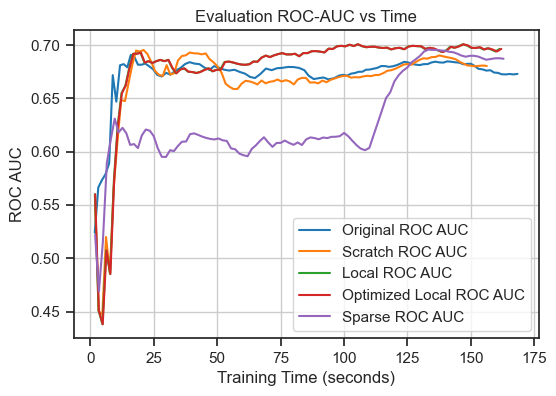

In [259]:
from visualisation import plot_metric
plot_metric("ROC vs time", model_histories)

#### Training and Inference time 

In [269]:
import importlib
import visualisation
importlib.reload(visualisation)

<module 'visualisation' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\visualisation.py'>

In [279]:
from visualisation import summarize_training_times
training_times = summarize_training_times(model_histories)


In [272]:
model_state_dicts = {"Original": "saved_models/nanotabpfn_original_prior_trained_seed0.pt", 
                   "Scratch": "saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt", 
                   "Local": "saved_models/nanotabpfn_local_attention_from_scratch_prior_trained_seed0.pt", 
                   "Optimized Local": "saved_models/nanotabpfn_optimized_local_attention_prior_trained_seed0.pt", 
                   "Sparse": "saved_models/nanotabpfn_sparse_attention_prior_trained_seed0.pt"}

In [273]:
from visualisation import measure_inference_time_from_state_dict, collect_inference_times
from train import PriorDumpDataLoader

In [274]:
inferences = collect_inference_times(model_state_dicts)

saved_models/nanotabpfn_original_prior_trained_seed0.pt Original
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_original_prior_trained_seed0.pt Original
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_original_prior_trained_seed0.pt Original
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_original_prior_trained_seed0.pt Original
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt Scratch
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt Scratch
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt Scratch
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt Scratch
Finished iteration over all stored datasets! 
saved_models/nanotabpfn_local_attention_from_scratch_prior_t

In [278]:
merged = training_times.merge(inferences, on = "model name")
merged

,model name,full training time,average step time,40 rows,100 rows,500 rows,1000 rows
0,Original,168.414744,0.066648,0.000826,0.000786,0.005496,0.014644
1,Scratch,156.304359,0.062294,0.000598,0.000728,0.005848,0.015453
2,Local,161.355131,0.064910,0.000633,0.001191,0.007079,0.014099
3,Optimized Local,162.028252,0.064816,0.000715,0.000958,0.008240,0.022802
4,Sparse,162.902627,0.064493,0.000894,0.000893,0.007427,0.021958


In [280]:
for name, state_dict in model_state_dicts.items():
    for num_rows in ["40_30", "100_80", "500_400", "1000_800"]:
        dataset = PriorDumpDataLoader(f"h5_files/evaluation_wine_dataset_{num_rows}_rows.h5", 
                              num_steps = 50, 
                              batch_size = 10)
        inf_time = measure_inference_time_from_state_dict(state_dict, 
                                                  embedding_size = 96, 
                                                  num_heads= 4, 
                                                  mlp_hidden_size= 192, 
                                                  num_layers= 3, 
                                                  num_outputs= 3, 
                                                  attention_type=name, 
                                                  dataset = dataset
                                                    )
        print(num_rows, name, inf_time )

c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\visualisation.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path, map_lo

Finished iteration over all stored datasets! 
40_30 Original 0.0008180937767028808
Finished iteration over all stored datasets! 
100_80 Original 0.0007130308151245117
Finished iteration over all stored datasets! 
500_400 Original 0.005535972595214844
Finished iteration over all stored datasets! 
1000_800 Original 0.01477993869781494
Finished iteration over all stored datasets! 
40_30 Scratch 0.0008384490013122559
Finished iteration over all stored datasets! 
100_80 Scratch 0.0007698354721069336
Finished iteration over all stored datasets! 
500_400 Scratch 0.005761989116668701
Finished iteration over all stored datasets! 
1000_800 Scratch 0.01572149085998535
window_size 20
window_size 20
window_size 20
Finished iteration over all stored datasets! 
40_30 Local 0.0007131471633911133
window_size 20
window_size 20
window_size 20
Finished iteration over all stored datasets! 
100_80 Local 0.0012404623031616211
window_size 20
window_size 20
window_size 20
Finished iteration over all stored dat

## Creating our own priors

In [192]:
import h5py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import openml

In [201]:
import importlib
import preprocessing
importlib.reload(preprocessing) #il faut reload l'importer des que tu fais un changement a la classe

<module 'preprocessing' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\preprocessing.py'>

In [202]:
from preprocessing import create_h5_prior_from_dataset

In [249]:
create_h5_prior_from_dataset(40691, "h5_files/evaluation_wine_dataset_40_30_rows.h5", num_tasks = 500, total_rows = 40, train_rows = 30)
create_h5_prior_from_dataset(40691, "h5_files/evaluation_wine_dataset_100_80_rows.h5", num_tasks = 500, total_rows = 100, train_rows = 80)
create_h5_prior_from_dataset(40691, "h5_files/evaluation_wine_dataset_500_400_rows.h5", num_tasks = 500, total_rows = 500, train_rows = 400)
create_h5_prior_from_dataset(40691, "h5_files/evaluation_wine_dataset_1000_800_rows.h5", num_tasks = 500, total_rows = 1000, train_rows = 800)

c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


table size =  (1599, 11)
Saved tasks here here  to h5_files/evaluation_wine_dataset_40_30_rows.h5


c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


table size =  (1599, 11)
Saved tasks here here  to h5_files/evaluation_wine_dataset_100_80_rows.h5


c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


table size =  (1599, 11)
Saved tasks here here  to h5_files/evaluation_wine_dataset_500_400_rows.h5


c:\Users\gregg\OneDrive\Desktop\Salome\Neuralk_NanoTabFPN\preprocessing.py:12: FutureWarning: ``download_all_files`` is experimental and is likely to break with new releases.
  dataset = openml.datasets.get_dataset(dataset_id, download_all_files=True)


table size =  (1599, 11)
Saved tasks here here  to h5_files/evaluation_wine_dataset_1000_800_rows.h5


In [209]:
import importlib
import visualisation
importlib.reload(visualisation)

<module 'visualisation' from 'c:\\Users\\gregg\\OneDrive\\Desktop\\Salome\\Neuralk_NanoTabFPN\\visualisation.py'>

In [211]:
from visualisation import measure_inference_time_from_state_dict
from train import PriorDumpDataLoader

dataset = PriorDumpDataLoader("h5_files/evaluation_wine_dataset_500_rows.h5", 
                              num_steps = 50, 
                              batch_size = 10)
inf_time = measure_inference_time_from_state_dict("saved_models/nanotabpfn_attention_from_scratch_prior_trained_seed0.pt", 
                                                  embedding_size = 96, 
                                                  num_heads= 4, 
                                                  mlp_hidden_size= 192, 
                                                  num_layers= 3, 
                                                  num_outputs= 3, 
                                                  attention_type="Scratch", 
                                                  dataset = dataset
                                                    )

Finished iteration over all stored datasets! 


In [212]:
print(inf_time)

0.006033627033233643


In [146]:
file_path = "h5_files/evaluation_wine_dataset.h5"  # or your file
with h5py.File(file_path, "r") as f:
    # List top-level keys
    print(f)
    print("Keys:", list(f.keys()))

    X = f['X'][:]
    print(X.shape)
    y = f['y'][:]
    print(y.shape)
    print(y.dtype)
    print(y[0])
    # Explore a single task
    first_task_key = list(f.keys())[0]
    print("Task key:", first_task_key)
    
    task_data = f[first_task_key]

<HDF5 file "evaluation_wine_dataset.h5" (mode r)>
Keys: ['X', 'max_num_classes', 'num_datapoints', 'num_features', 'single_eval_pos', 'y']
(500, 40, 11)
(500, 40)
float32
[3. 2. 2. 2. 2. 4. 2. 2. 2. 4. 3. 2. 3. 2. 3. 1. 3. 2. 3. 1. 2. 3. 3. 3.
 3. 3. 3. 3. 3. 2. 3. 2. 2. 2. 2. 2. 4. 3. 2. 3.]
Task key: X
